## 1. Importing The Modules

In [1]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

## 2. Loading The Data

In [2]:
direc = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Trout
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Shrimp


### 2.1 Displaying First 9 Images

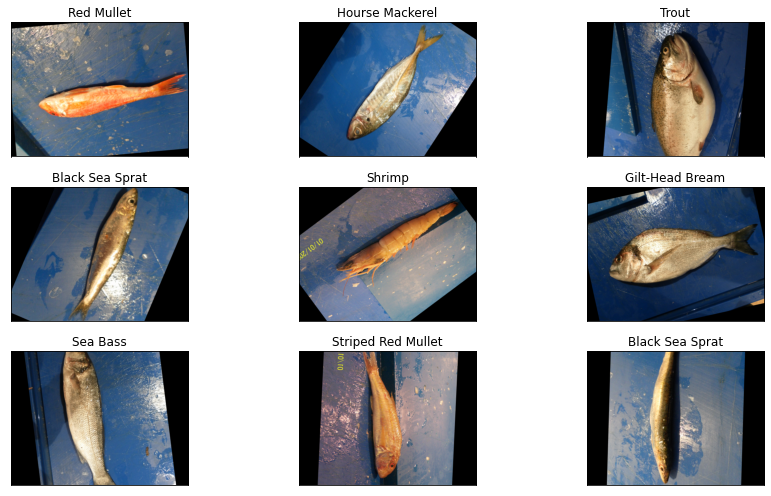

In [3]:
# Showing 9Images 
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()


### 2.2 Shape Of DataFrame

In [4]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


### 2.3 Types Of Fishes

In [5]:
img_df['Labels'].value_counts(ascending=True)

Gilt-Head Bream       1000
Trout                 1000
Striped Red Mullet    1000
Hourse Mackerel       1000
Shrimp                1000
Red Mullet            1000
Black Sea Sprat       1000
Sea Bass              1000
Red Sea Bream         1000
Name: Labels, dtype: int64

## 3. Splitting The Data

In [6]:
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15


x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()


Shape of Training Data :  (6750, 2)
Shape of Testing Data :  (1350, 2)
Shape of Validation Data :  (900, 2)


### 3.1 Augmenating The Data

In [7]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


> 1. Scaling input pixels to (-1,1).


## 3.2 Transfer Learning

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    for layer in base_model.layers[-2:]:
        layer.trainable = True

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output_layer = tf.keras.layers.Dense(9, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

mo_fit = model.fit(x_train, validation_data=x_val, epochs=3, callbacks=[Callback])


Epoch 1/3
211/211 [==============================] - 365s 2s/step - loss: 1.0403 - accuracy: 0.7012 - val_loss: 0.0315 - val_accuracy: 0.9889
Epoch 2/3
211/211 [==============================] - 358s 2s/step - loss: 0.0326 - accuracy: 0.9895 - val_loss: 0.0171 - val_accuracy: 0.9933
Epoch 3/3
211/211 [==============================] - 355s 2s/step - loss: 0.0201 - accuracy: 0.9950 - val_loss: 0.0195 - val_accuracy: 0.9933


## 3.3 Training The Model

In [13]:
test_accuracy = model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )


43/43 [==============================] - 67s 2s/step - loss: 0.0353 - accuracy: 0.9919
Test accuracy is :  99.18518662452698 %
